In [3]:
import pandas as pd
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [4]:
cn7 = pd.read_csv("./data/labeled_data.csv")
cn7 = cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD", "Reason", "Clamp_Open_Position",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])
cn7 = cn7[(cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G RH") | (cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G LH")]
cn7 = cn7.drop(columns=["PART_NAME"])
cn7 = cn7.replace("Y", 1).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_21132\3887624601.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7 = cn7.replace("Y", 1).replace("N", 0)


In [5]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [6]:
cn7_pass = cn7[cn7["PassOrFail"] == 1]
cn7_fail = cn7[cn7["PassOrFail"] == 0]
cn7_pass_removed = cn7_pass.copy()
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Injection_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Plasticizing_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Cycle_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Max_Injection_Speed')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Mold_Temperature_3')
cn7_removed = pd.concat([cn7_pass_removed, cn7_fail], ignore_index=True)


In [7]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터프레임 생성 (예시)
# df = pd.read_csv('your_data.csv')  # 본인의 데이터셋을 불러오세요.

# PassOrFail 컬럼은 종속변수로 사용되므로 제외하고 독립변수만 선택
X = cn7_pass_removed.drop(columns=['PassOrFail'])

# VIF 계산 함수 정의
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(X)

# 결과 출력
print(vif_result)


                     Feature           VIF
0             Injection_Time  5.009665e+06
1               Filling_Time  1.037999e+06
2          Plasticizing_Time  3.064700e+05
3                 Cycle_Time  1.041551e+07
4           Clamp_Close_Time  3.617912e+06
5           Cushion_Position  2.600254e+07
6      Plasticizing_Position  4.122140e+06
7        Max_Injection_Speed  8.601012e+05
8              Max_Screw_RPM  8.065826e+04
9          Average_Screw_RPM  2.923977e+01
10    Max_Injection_Pressure  6.477393e+06
11  Max_Switch_Over_Pressure  7.357289e+05
12         Max_Back_Pressure  2.148512e+05
13     Average_Back_Pressure  1.658576e+06
14      Barrel_Temperature_1  4.424607e+05
15      Barrel_Temperature_2  5.807720e+05
16      Barrel_Temperature_3  8.214770e+05
17      Barrel_Temperature_4  1.903467e+05
18      Barrel_Temperature_5  6.486477e+05
19      Barrel_Temperature_6  1.153868e+06
20        Hopper_Temperature  1.518053e+04
21        Mold_Temperature_3  2.073732e+04
22        M

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [7]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999119,0.997947,0.996109,1.000000,0.998051,0.001172,10,4,4,1954,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.998678,0.998973,1.000000,0.998047,0.999022,-0.000295,10,4,4,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999119,0.988706,0.994083,0.984375,0.989205,0.010413,11,3,4,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.991786,0.996063,0.988281,0.992157,0.007773,10,4,7,1951,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999119,0.996920,0.998043,0.996094,0.997067,0.002199,10,4,17,1941,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


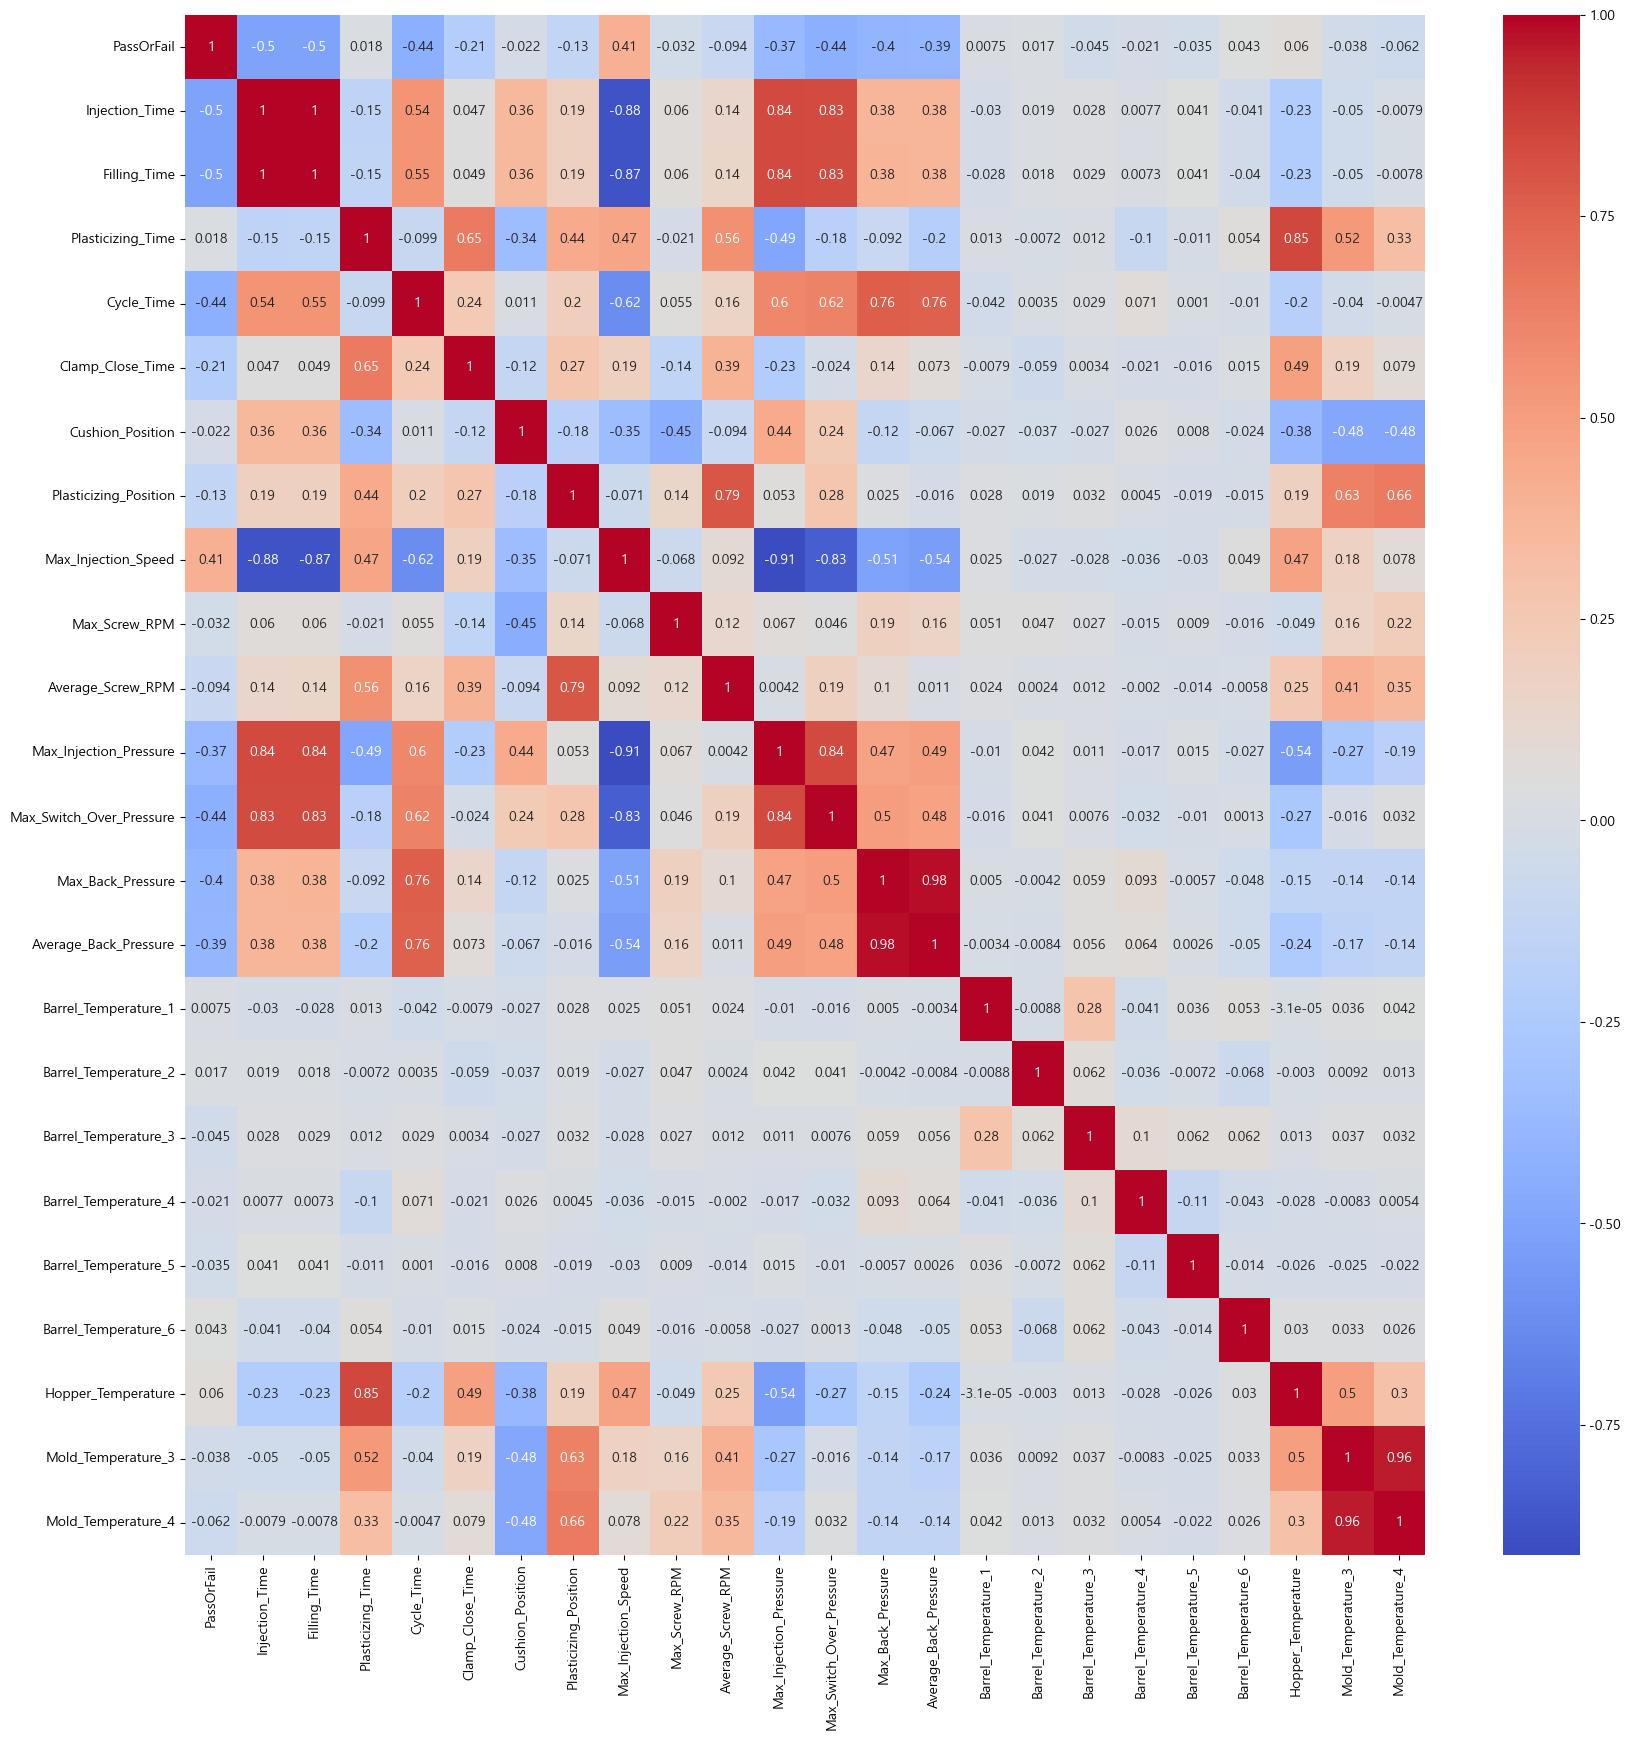

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()

plt.savefig('/heatmap.png', dpi=300, bbox_inches='coolwarm')
plt.close()


In [29]:
cn7_test = cn7_removed.drop(columns=['Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'])

In [30]:
cn7_removed.columns

Index(['PassOrFail', 'Injection_Time', 'Filling_Time', 'Plasticizing_Time',
       'Cycle_Time', 'Clamp_Close_Time', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Injection_Speed', 'Max_Screw_RPM',
       'Average_Screw_RPM', 'Max_Injection_Pressure',
       'Max_Switch_Over_Pressure', 'Max_Back_Pressure',
       'Average_Back_Pressure', 'Barrel_Temperature_1', 'Barrel_Temperature_2',
       'Barrel_Temperature_3', 'Barrel_Temperature_4', 'Barrel_Temperature_5',
       'Barrel_Temperature_6', 'Hopper_Temperature', 'Mold_Temperature_3',
       'Mold_Temperature_4'],
      dtype='object')

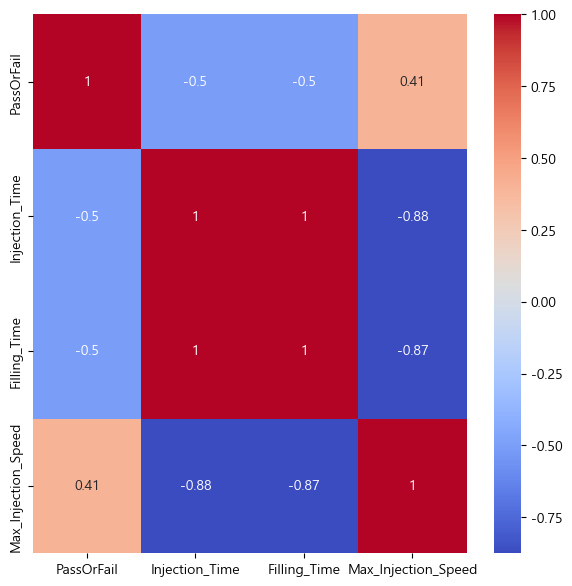

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.heatmap(cn7_test.corr(), annot=True, cmap='coolwarm')
plt.show()

In [9]:
cn7_removed = cn7_removed.drop(columns = ["Filling_Time", "Average_Back_Pressure", "Mold_Temperature_3", "Max_Injection_Pressure",
                                          "Plasticizing_Time", "Max_Injection_Speed"])

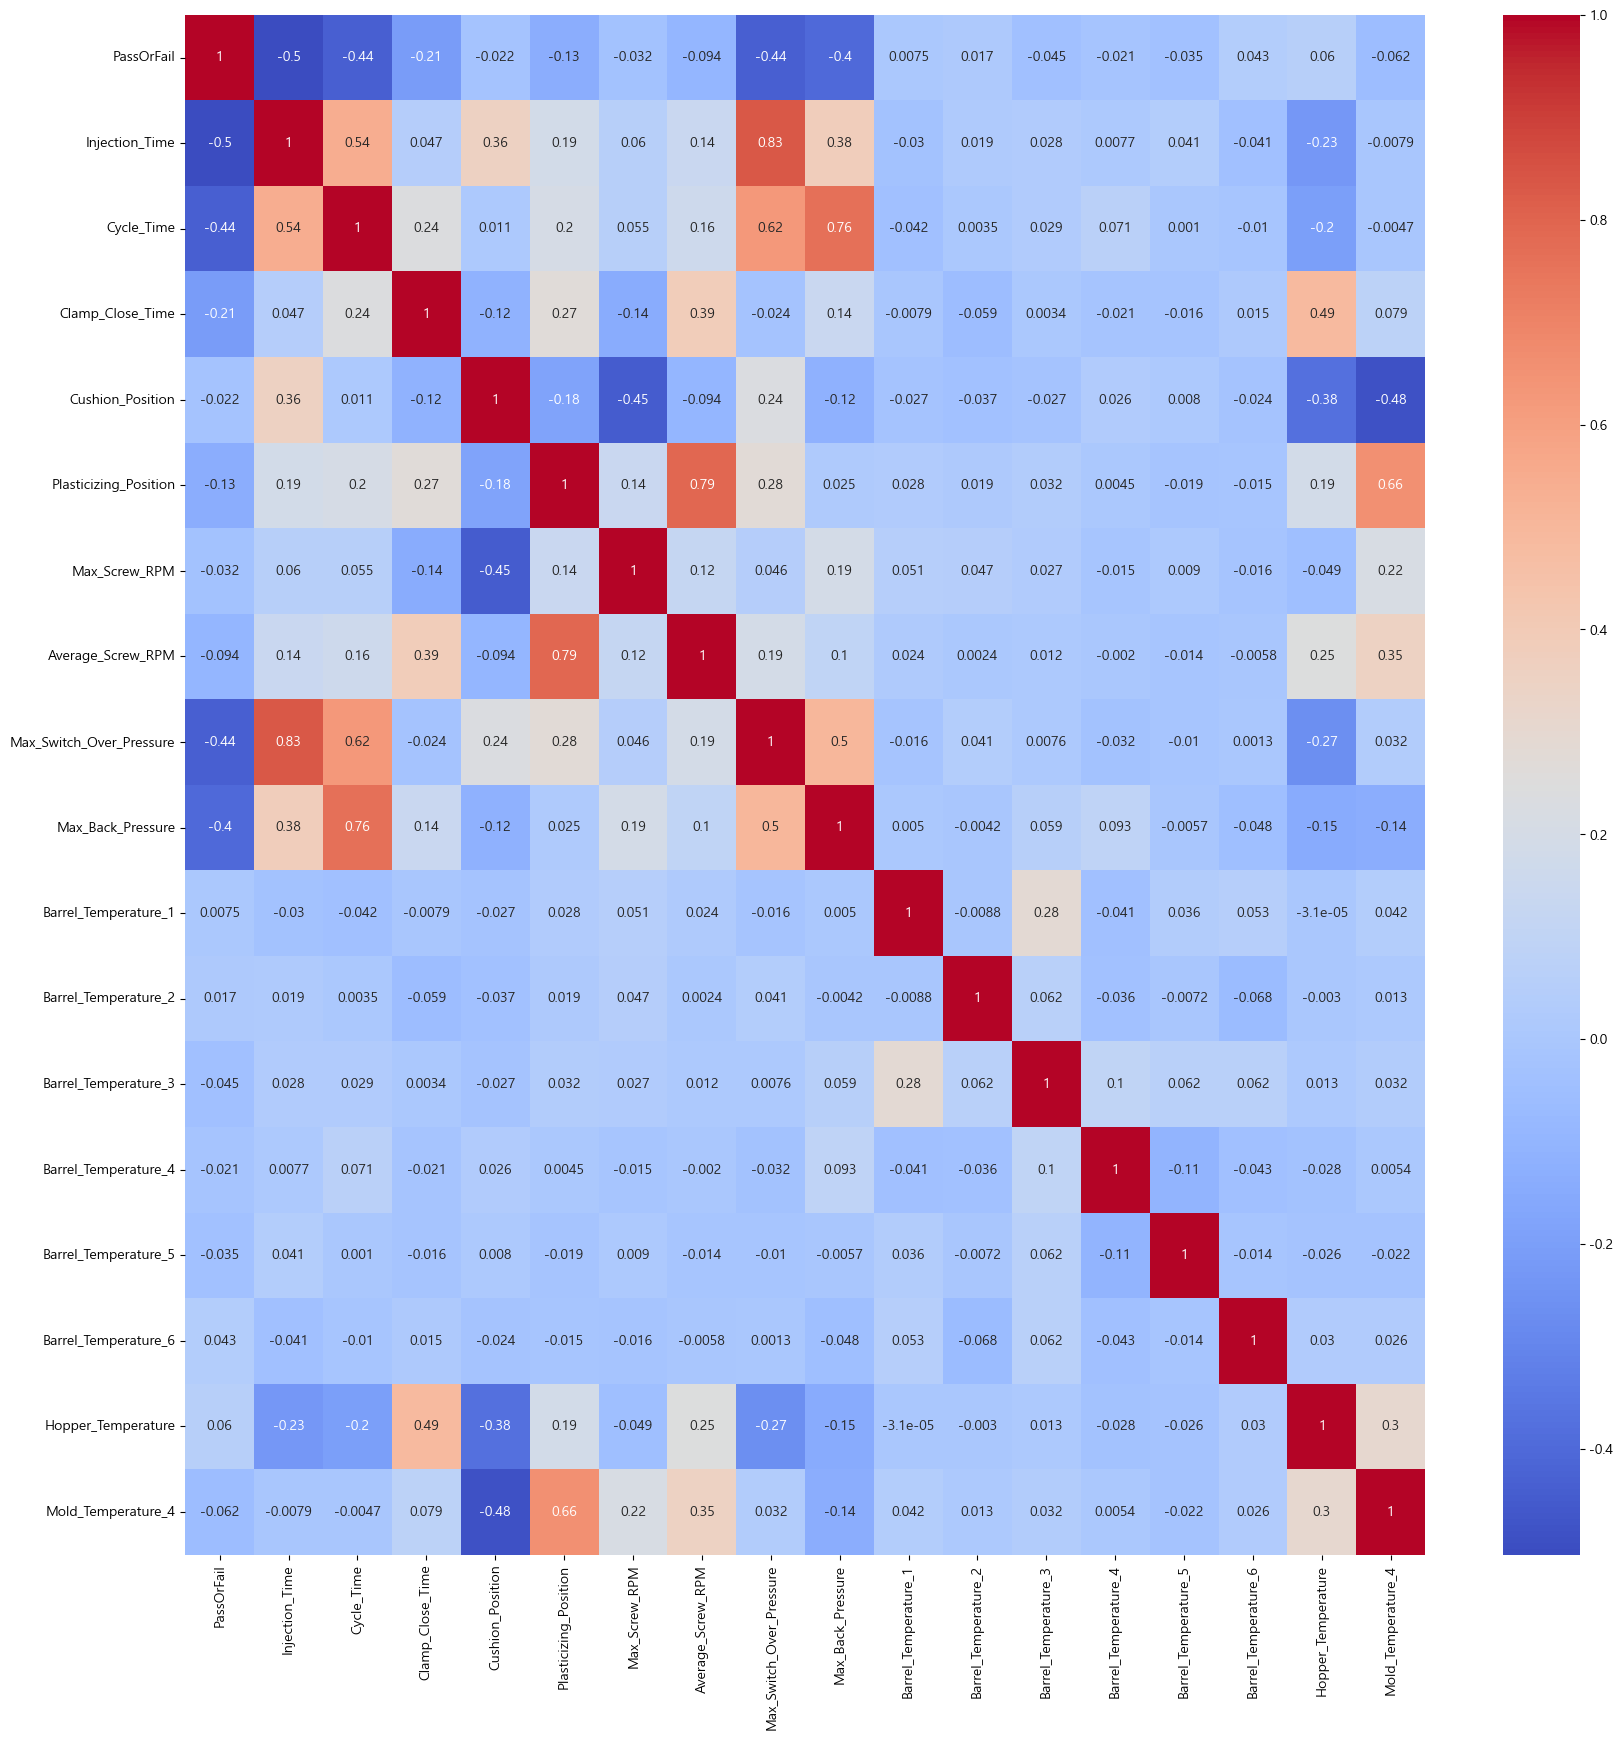

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()

In [110]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.998238,0.998973,1.000000,0.998047,0.999022,-0.000735,10,4,3,1955,"{'max_depth': 20, 'min_samples_leaf': 4, 'min_..."
1,ExtraTreesClassifier,0.999119,0.997947,0.998047,0.998047,0.998047,0.001172,10,4,2,1956,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999559,0.991786,0.994118,0.990234,0.992172,0.007773,12,2,5,1953,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.991786,0.996063,0.988281,0.992157,0.007773,12,2,6,1952,"{'max_depth': 10, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.999559,0.994867,0.996086,0.994141,0.995112,0.004693,10,4,2,1956,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터프레임 생성 (예시)
# df = pd.read_csv('your_data.csv')  # 본인의 데이터셋을 불러오세요.

# PassOrFail 컬럼은 종속변수로 사용되므로 제외하고 독립변수만 선택
X = labeled_cn7.drop(columns=['PassOrFail'])

# VIF 계산 함수 정의
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

# VIF 계산
vif_result = calculate_vif(X)

# 결과 출력
print(vif_result)


In [111]:
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

from scipy.stats import spearmanr, pearsonr

X_columns_nm = cn7_removed.columns

for col in X_columns_nm:
    s, p = spearmanr(cn7_removed[col], y)
    msg = f"""
        독립변수({col})와 종속변수(PassOrFail)의 상관관계 계수는 {s:.7f}이고, p-value의 값은 {p:.7f} 입니다.
    """
    print(msg)


        독립변수(PassOrFail)와 종속변수(PassOrFail)의 상관관계 계수는 1.0000000이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Injection_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0584807이고, p-value의 값은 0.0000021 입니다.
    

        독립변수(Cycle_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0376849이고, p-value의 값은 0.0022448 입니다.
    

        독립변수(Clamp_Close_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0904653이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Cushion_Position)와 종속변수(PassOrFail)의 상관관계 계수는 0.0613242이고, p-value의 값은 0.0000007 입니다.
    

        독립변수(Plasticizing_Position)와 종속변수(PassOrFail)의 상관관계 계수는 -0.1093167이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0226715이고, p-value의 값은 0.0660684 입니다.
    

        독립변수(Average_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0865881이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Switch_Over_Pressure)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0847787이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Back_Pressure)와 종속변수(PassOrFail)의

In [112]:
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

from scipy.stats import spearmanr, pearsonr

X_columns_nm = cn7_removed.columns

for col in X_columns_nm:
    s, p = pearsonr(cn7_removed[col], y)
    msg = f"""
        독립변수({col})와 종속변수(PassOrFail)의 상관관계 계수는 {s:.7f}이고, p-value의 값은 {p:.7f} 입니다.
    """
    print(msg)


        독립변수(PassOrFail)와 종속변수(PassOrFail)의 상관관계 계수는 1.0000000이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Injection_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.5033333이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Cycle_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.4380535이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Clamp_Close_Time)와 종속변수(PassOrFail)의 상관관계 계수는 -0.2122418이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Cushion_Position)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0224514이고, p-value의 값은 0.0687420 입니다.
    

        독립변수(Plasticizing_Position)와 종속변수(PassOrFail)의 상관관계 계수는 -0.1335699이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0323693이고, p-value의 값은 0.0086777 입니다.
    

        독립변수(Average_Screw_RPM)와 종속변수(PassOrFail)의 상관관계 계수는 -0.0939293이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Switch_Over_Pressure)와 종속변수(PassOrFail)의 상관관계 계수는 -0.4369056이고, p-value의 값은 0.0000000 입니다.
    

        독립변수(Max_Back_Pressure)와 종속변수(PassOrFail)

In [113]:
cn7_removed_temp = cn7_removed.drop(columns = ["Max_Screw_RPM", "Max_Back_Pressure", "Barrel_Temperature_1", 
                                          "Barrel_Temperature_2","Barrel_Temperature_3", "Barrel_Temperature_4",
                                          "Barrel_Temperature_5", "Barrel_Temperature_6", "Mold_Temperature_4"])

In [114]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.998238,0.996920,0.994175,1.000000,0.997079,0.001318,11,3,4,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.998678,0.997947,1.000000,0.996094,0.998043,0.000732,11,3,8,1950,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999559,0.994867,0.996086,0.994141,0.995112,0.004693,10,4,2,1956,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.998678,0.993840,0.998031,0.990234,0.994118,0.004839,11,3,3,1955,"{'max_depth': 50, 'max_iter': 20, 'min_samples..."
4,XGBClassifier,0.998678,0.997947,1.000000,0.996094,0.998043,0.000732,10,4,5,1953,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


In [115]:
cn7_removed_temp = cn7_removed_temp.drop(columns = ["Cushion_Position"])

In [116]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp["PassOrFail"]
X = cn7_removed_temp.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999559,0.996920,0.996101,0.998047,0.997073,0.002640,11,3,5,1953,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.998238,0.997947,1.000000,0.996094,0.998043,0.000291,11,3,9,1949,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.998678,0.994867,0.994152,0.996094,0.995122,0.003812,10,4,1,1957,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.992813,0.994129,0.992188,0.993157,0.006746,10,4,3,1955,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.998678,0.997947,0.998047,0.998047,0.998047,0.000732,10,4,3,1955,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


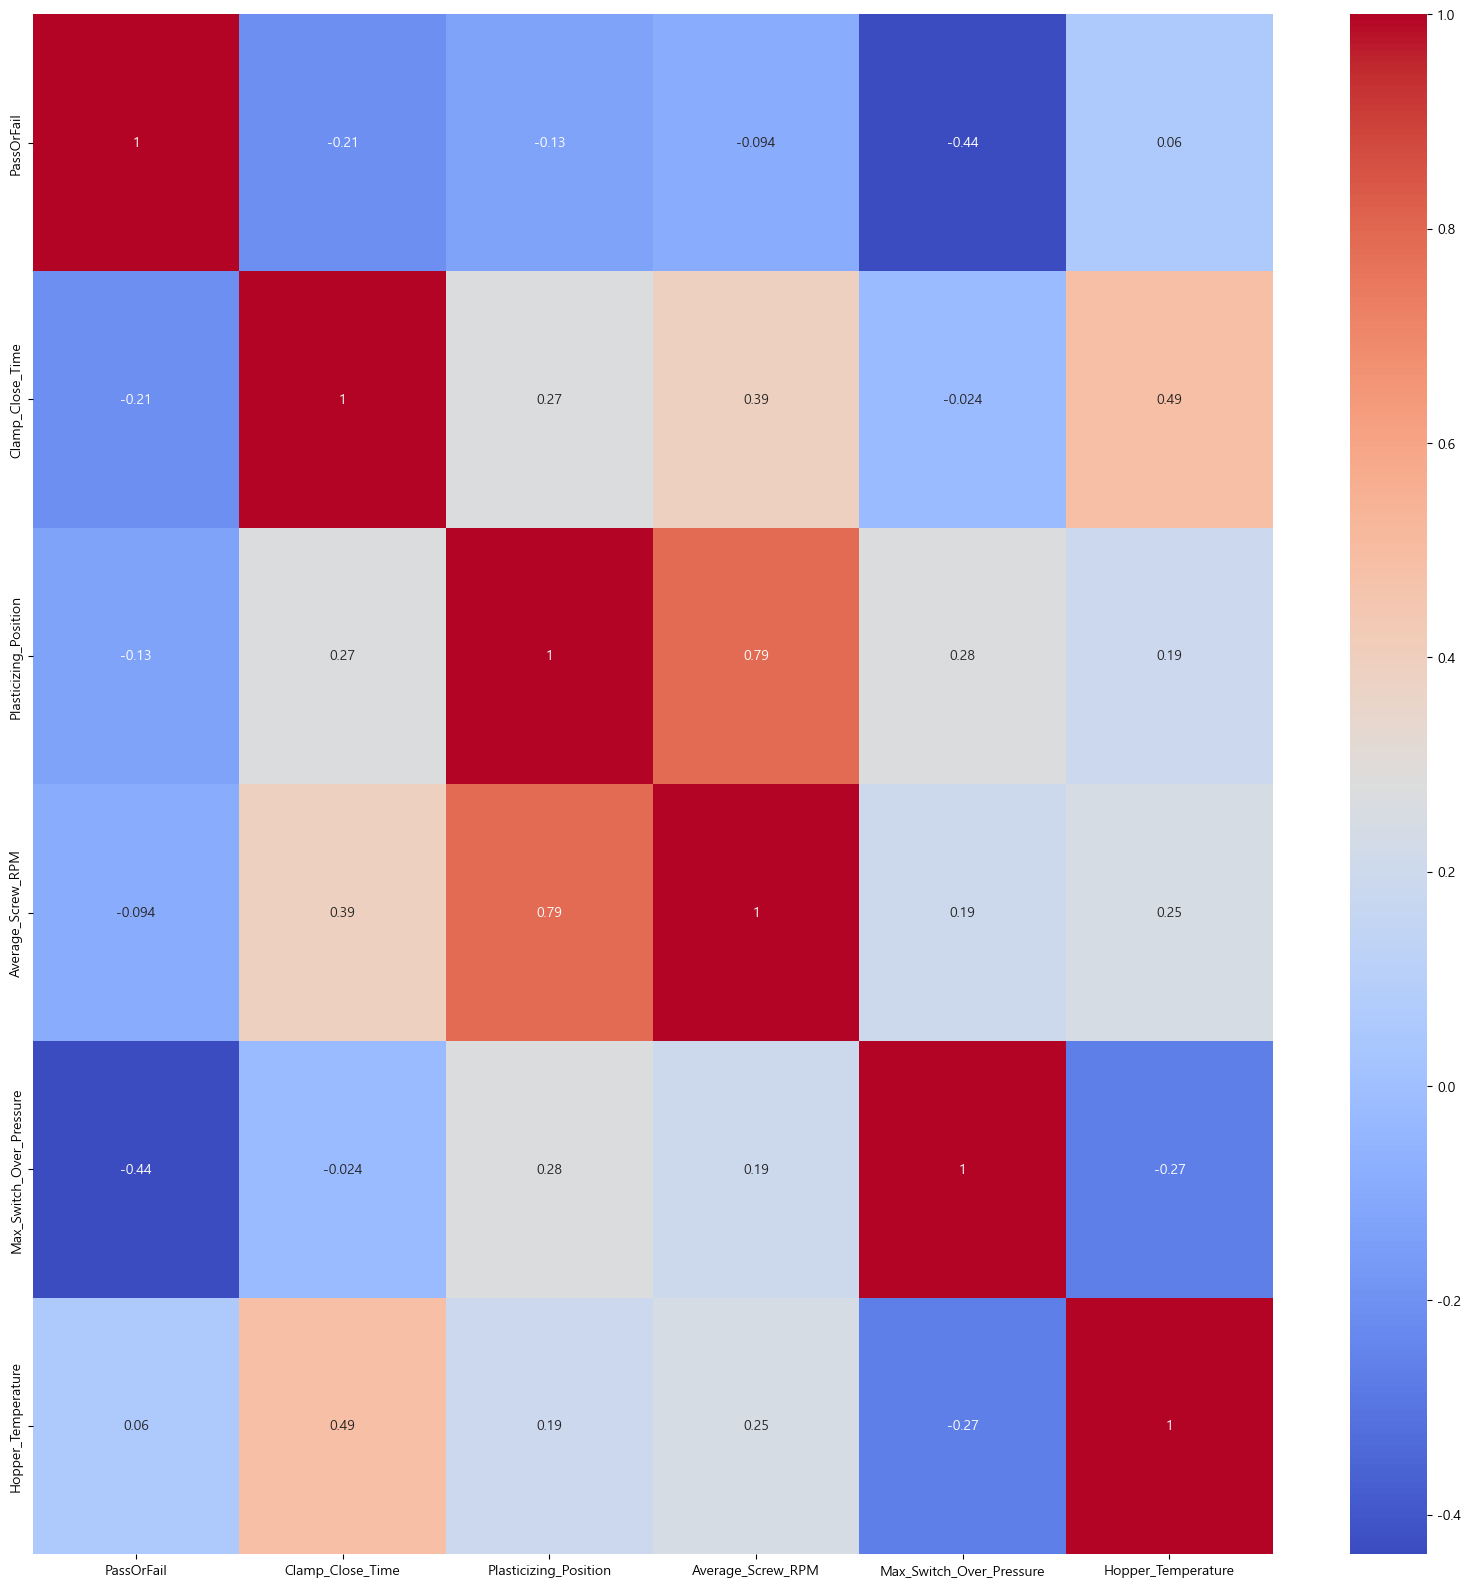

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed_temp3.corr(), annot=True, cmap='coolwarm')
plt.show()

In [118]:
cn7_removed_temp1 = cn7_removed_temp.drop(columns = ["Injection_Time"])

In [119]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp1["PassOrFail"]
X = cn7_removed_temp1.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.997797,0.995893,0.996094,0.996094,0.996094,0.001904,13,1,7,1951,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.998238,0.996920,0.998043,0.996094,0.997067,0.001318,12,2,10,1948,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.997357,0.988706,0.996040,0.982422,0.989184,0.008650,11,3,11,1947,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.987680,0.994071,0.982422,0.988212,0.011880,12,2,11,1947,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999559,0.993840,0.996078,0.992188,0.994129,0.005720,12,2,4,1954,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [120]:
cn7_removed_temp2 = cn7_removed_temp.drop(columns = ["Max_Switch_Over_Pressure"])

In [123]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp2["PassOrFail"]
X = cn7_removed_temp2.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.996476,0.996920,0.998043,0.996094,0.997067,-0.000444,10,4,13,1945,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.997797,0.997947,0.998047,0.998047,0.998047,-0.000149,10,4,11,1947,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999119,0.996920,0.996101,0.998047,0.997073,0.002199,10,4,5,1953,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.998678,0.994867,0.996086,0.994141,0.995112,0.003812,10,4,4,1954,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.997357,0.997947,0.998047,0.998047,0.998047,-0.000590,10,4,7,1951,"{'max_depth': 20, 'min_child_weight': 1, 'n_es..."


In [136]:
cn7_removed_temp3 = cn7_removed_temp1.drop(columns = ["Cycle_Time"])

In [139]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed_temp3["PassOrFail"]
X = cn7_removed_temp3.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.996916,0.991786,0.996063,0.988281,0.992157,0.005130,13,1,7,1951,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
1,ExtraTreesClassifier,0.999119,0.993840,0.996078,0.992188,0.994129,0.005279,12,2,9,1949,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999559,0.986653,0.994059,0.980469,0.987217,0.012906,12,2,10,1948,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.986653,0.996024,0.978516,0.987192,0.012906,12,2,11,1947,"{'max_depth': 10, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999559,0.985626,0.996016,0.976562,0.986193,0.013933,12,2,12,1946,"{'max_depth': 10, 'min_child_weight': 1, 'n_es..."


In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = cn7_removed_temp3["PassOrFail"]
X = cn7_removed_temp3.drop(columns=["PassOrFail"])

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. 전체 모델 학습 및 성능 측정
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_test, model.predict(X_test))
print(f"Baseline Accuracy: {baseline_accuracy}")

# 2. 각 변수 제거 후 성능 측정
importances = []
for col in X.columns:
    # 해당 변수를 제거한 데이터셋 생성
    X_train_dropped = X_train.drop(columns=[col])
    X_test_dropped = X_test.drop(columns=[col])
    
    # 모델 재학습 및 성능 측정
    model.fit(X_train_dropped, y_train)
    dropped_accuracy = accuracy_score(y_test, model.predict(X_test_dropped))
    
    # 변수 중요도 계산 (성능 하락량)
    importance = baseline_accuracy - dropped_accuracy
    importances.append((col, importance))

# 3. 결과 정렬 및 출력
importances.sort(key=lambda x: x[1], reverse=True)
for feature, importance in importances:
    print(f"Feature: {feature}, Importance: {importance}")

Baseline Accuracy: 0.9964503042596349
Feature: Max_Switch_Over_Pressure, Importance: 0.007606490872210991
Feature: Clamp_Close_Time, Importance: 0.0005070993914807476
Feature: Plasticizing_Position, Importance: 0.0
Feature: Average_Screw_RPM, Importance: 0.0
Feature: Hopper_Temperature, Importance: 0.0
